In [27]:
import tensorflow as tf
tf.__version__
tf.config.experimental.enable_op_determinism()
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)

In [28]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt
import random

In [29]:
def plot_columns(df):
    colors = plt.cm.tab20(range(df.shape[1]))  

    for i, column in enumerate(df.columns):
        color = colors[i % 24]

        plt.figure()
        plt.plot(df.index, df[column], color=color)
        plt.xlabel('Tempo')
        plt.ylabel('Valor')
        plt.title(column)

    plt.show()

In [30]:
def plot_correlation_matrix(df):
    correlation_matrix = df.corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title("Correlation Matrix Heatmap")
    plt.show()

In [31]:
tf.keras.backend.clear_session()

In [32]:
subject = 'Piauí - Consumo de Cimento (t)'
start_index = 0
split_index = 179
window_size = 36
train_split = split_index + 1 - 12

In [33]:
data = pd.read_csv('2003_mo_model_input_PI.csv')
pd.set_option('display.max_columns', None)
data

,Unnamed: 0,IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),Taxa Selic (%),IGP-DI,População,Estoque liquido de capital fixo - (R$),INCC (%),Piauí - IDH,Piauí - Produção de Cimento (t),Piauí - Consumo de Cimento (t),Piauí - PIB - Estadual,Piauí - PIB - Construção Civil,Piauí - PIB - Per Capita,Piauí - PIB - Preços de Mercado,Piauí - Desemprego
0,2003-1,0.724032,-5331.049150,11.520143,1.639718,1.036534,1.772069e+08,7.330309e+06,0.969649,0.649218,24.669760,21.844,2.136063e+07,1.358044e+06,6.061141,1.868149e+07,8.192266
1,2003-2,0.690297,-5318.079644,11.189862,1.378899,0.993449,1.773884e+08,7.335910e+06,0.950783,0.649661,25.167145,15.814,2.139102e+07,1.359835e+06,6.065065,1.869506e+07,8.186156
2,2003-3,0.669681,-5436.417870,10.820792,1.924317,0.973020,1.775699e+08,7.341511e+06,0.938332,0.650104,25.520404,16.067,2.142142e+07,1.361626e+06,6.068988,1.870864e+07,8.180046
3,2003-4,0.660494,-5707.015274,10.417840,1.331174,0.940489,1.777514e+08,7.347112e+06,0.926401,0.650548,25.519725,14.938,2.145181e+07,1.363417e+06,6.072912,1.872222e+07,8.173937
4,2003-5,0.648337,-5599.317941,9.959690,1.736072,0.917493,1.779329e+08,7.352713e+06,0.951683,0.650991,25.929312,17.765,2.148221e+07,1.365208e+06,6.076835,1.873580e+07,8.167827
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235,2022-8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.957215,77.776,NaN,NaN,NaN,NaN,NaN
236,2022-9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.965575,72.377,NaN,NaN,NaN,NaN,NaN
237,2022-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.977734,71.791,NaN,NaN,NaN,NaN,NaN
238,2022-11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.994123,71.015,NaN,NaN,NaN,NaN,NaN


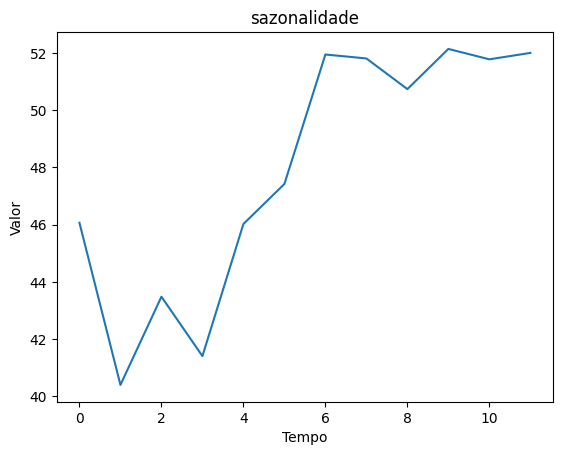

,sazonalidade
sazonalidade,
0,46.064857
1,40.394071
2,43.479464
3,41.402071
4,46.022714
5,47.422286
6,51.949714
7,51.811786
8,50.738929


In [34]:
def calculate_monthly_means(consume_of_cement, subject):
    df = pd.DataFrame({subject: consume_of_cement[:train_split]})
    df['sazonalidade'] = df.index % 12
    monthly_means = df.groupby('sazonalidade')[subject].mean()
    result_df = pd.DataFrame({'sazonalidade': monthly_means})

    return result_df

media_df = calculate_monthly_means(data[subject], subject)
plot_columns(media_df)
media_df

In [35]:
def fill_original_df_with_monthly_means(df_og, media_df):
    monthly_means = media_df['sazonalidade'].tolist()
    df_og['sazonalidade'] = [monthly_means[i % 12] for i in range(len(df_og))]
    return df_og

data = fill_original_df_with_monthly_means(data, media_df)
data = data[[col for col in data.columns if col != subject] + [subject]] #Seta consumo (target) para a coluna final
data

,Unnamed: 0,IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),Taxa Selic (%),IGP-DI,População,Estoque liquido de capital fixo - (R$),INCC (%),Piauí - IDH,Piauí - Produção de Cimento (t),Piauí - PIB - Estadual,Piauí - PIB - Construção Civil,Piauí - PIB - Per Capita,Piauí - PIB - Preços de Mercado,Piauí - Desemprego,sazonalidade,Piauí - Consumo de Cimento (t)
0,2003-1,0.724032,-5331.049150,11.520143,1.639718,1.036534,1.772069e+08,7.330309e+06,0.969649,0.649218,24.669760,2.136063e+07,1.358044e+06,6.061141,1.868149e+07,8.192266,46.064857,21.844
1,2003-2,0.690297,-5318.079644,11.189862,1.378899,0.993449,1.773884e+08,7.335910e+06,0.950783,0.649661,25.167145,2.139102e+07,1.359835e+06,6.065065,1.869506e+07,8.186156,40.394071,15.814
2,2003-3,0.669681,-5436.417870,10.820792,1.924317,0.973020,1.775699e+08,7.341511e+06,0.938332,0.650104,25.520404,2.142142e+07,1.361626e+06,6.068988,1.870864e+07,8.180046,43.479464,16.067
3,2003-4,0.660494,-5707.015274,10.417840,1.331174,0.940489,1.777514e+08,7.347112e+06,0.926401,0.650548,25.519725,2.145181e+07,1.363417e+06,6.072912,1.872222e+07,8.173937,41.402071,14.938
4,2003-5,0.648337,-5599.317941,9.959690,1.736072,0.917493,1.779329e+08,7.352713e+06,0.951683,0.650991,25.929312,2.148221e+07,1.365208e+06,6.076835,1.873580e+07,8.167827,46.022714,17.765
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235,2022-8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.957215,NaN,NaN,NaN,NaN,NaN,51.811786,77.776
236,2022-9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.965575,NaN,NaN,NaN,NaN,NaN,50.738929,72.377
237,2022-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.977734,NaN,NaN,NaN,NaN,NaN,52.144929,71.791
238,2022-11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.994123,NaN,NaN,NaN,NaN,NaN,51.781071,71.015


In [36]:
# Shift para prever futuro e não presente
target_data = data[subject].shift(-24)
target_data

0      19.758
1      19.763
2      22.445
3      20.109
4      24.283
        ...  
235       NaN
236       NaN
237       NaN
238       NaN
239       NaN
Name: Piauí - Consumo de Cimento (t), Length: 240, dtype: float64

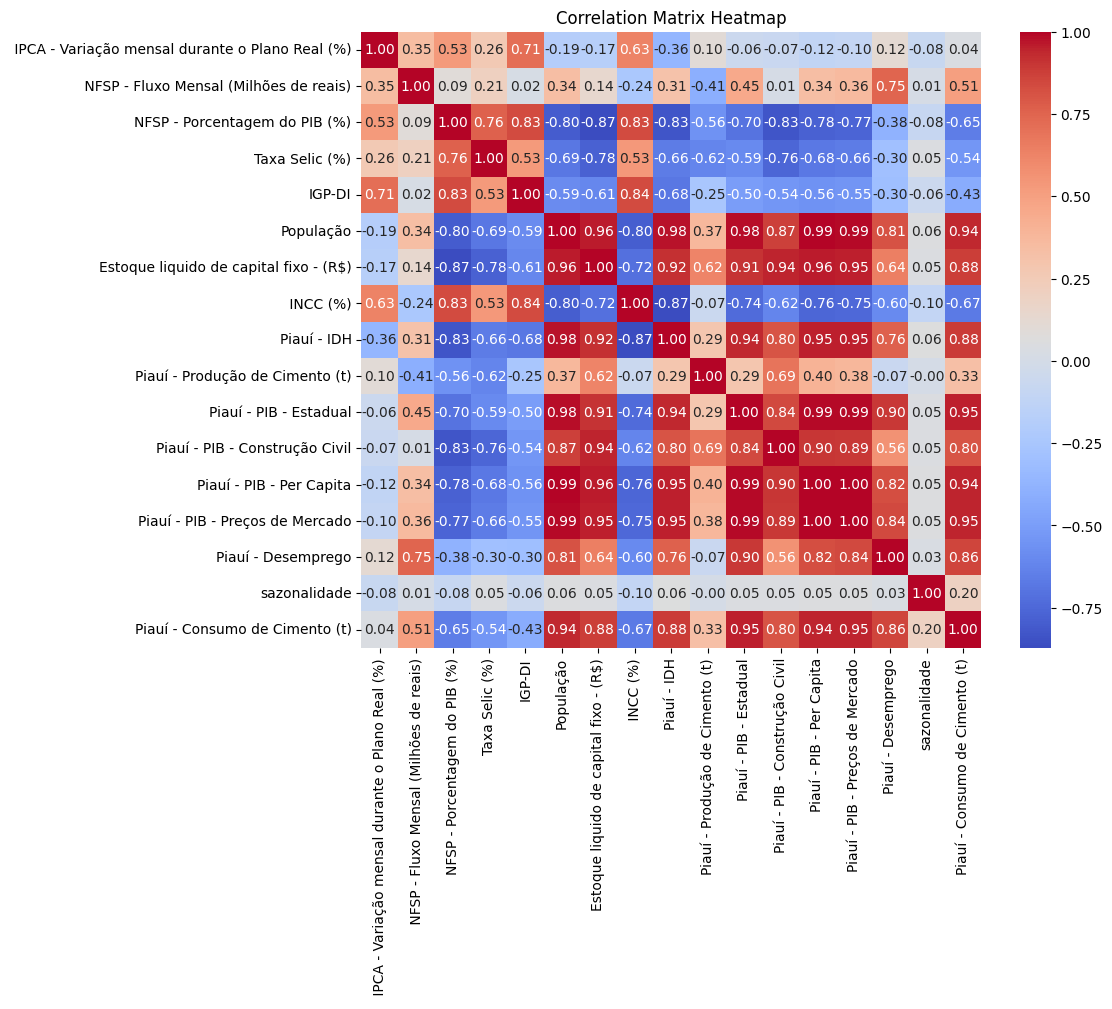

In [37]:
plot_data = data.iloc[:split_index + 1,1:]
plot_correlation_matrix(plot_data)

In [38]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

safe_data = data.iloc[:split_index + 1,1:-1]

def calculate_vif(dataframe):
    vif_data = pd.DataFrame()
    vif_data["Feature"] = dataframe.columns
    vif_data["VIF"] = [variance_inflation_factor(dataframe.values, i) for i in range(dataframe.shape[1])]
    return vif_data

def remove_high_vif_columns(dataframe, threshold=1000):
    i=0
    while True:
        vif_result = calculate_vif(dataframe)
        high_vif_column = vif_result.loc[vif_result["VIF"].idxmax()]["Feature"]
        
        if vif_result["VIF"].max() <= threshold:
            print(f"Num columns removed: {i}")
            return dataframe
        i += 1
        dataframe = dataframe.drop(high_vif_column, axis=1)

In [39]:
safe_data = data.iloc[:split_index + 1,1:-1]
vif_info = calculate_vif(safe_data)
vif_info

,Feature,VIF
0,IPCA - Variação mensal durante o Plano Real (%),1.631194e+03
1,NFSP - Fluxo Mensal (Milhões de reais),1.692170e+02
2,NFSP - Porcentagem do PIB (%),4.774102e+02
3,Taxa Selic (%),5.746710e+01
4,IGP-DI,2.552105e+02
5,População,8.189644e+06
6,Estoque liquido de capital fixo - (R$),1.085503e+07
7,INCC (%),1.675992e+03
8,Piauí - IDH,1.068749e+06
9,Piauí - Produção de Cimento (t),6.259108e+03


In [40]:
data = remove_high_vif_columns(safe_data, 1000000)
data

Num columns removed: 2


,IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),Taxa Selic (%),IGP-DI,População,Estoque liquido de capital fixo - (R$),INCC (%),Piauí - IDH,Piauí - Produção de Cimento (t),Piauí - PIB - Estadual,Piauí - PIB - Construção Civil,Piauí - Desemprego,sazonalidade
0,0.724032,-5331.049150,11.520143,1.639718,1.036534,1.772069e+08,7.330309e+06,0.969649,0.649218,24.669760,2.136063e+07,1.358044e+06,8.192266,46.064857
1,0.690297,-5318.079644,11.189862,1.378899,0.993449,1.773884e+08,7.335910e+06,0.950783,0.649661,25.167145,2.139102e+07,1.359835e+06,8.186156,40.394071
2,0.669681,-5436.417870,10.820792,1.924317,0.973020,1.775699e+08,7.341511e+06,0.938332,0.650104,25.520404,2.142142e+07,1.361626e+06,8.180046,43.479464
3,0.660494,-5707.015274,10.417840,1.331174,0.940489,1.777514e+08,7.347112e+06,0.926401,0.650548,25.519725,2.145181e+07,1.363417e+06,8.173937,41.402071
4,0.648337,-5599.317941,9.959690,1.736072,0.917493,1.779329e+08,7.352713e+06,0.951683,0.650991,25.929312,2.148221e+07,1.365208e+06,8.167827,46.022714
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,0.366904,-5783.316460,2.206994,0.545067,0.471521,1.987710e+08,7.783063e+06,0.378150,0.689639,21.765063,2.657953e+07,1.434520e+06,11.093842,51.811786
176,0.358935,-6001.730740,2.215328,0.782910,0.476827,1.988450e+08,7.780841e+06,0.377666,0.689608,21.232248,2.657830e+07,1.434662e+06,11.082529,50.738929
177,0.354313,-6454.887704,2.232466,0.909682,0.475427,1.989190e+08,7.778619e+06,0.377838,0.689577,20.784566,2.657706e+07,1.434804e+06,11.071216,52.144929
178,0.352728,-6243.191421,2.263185,1.050614,0.491301,1.989930e+08,7.776397e+06,0.370057,0.689545,20.341515,2.657583e+07,1.434946e+06,11.059902,51.781071


In [41]:
input_data = data.iloc[:split_index + 1,1:-1]
mean = np.mean(input_data, axis=0)
stddev =  np.std(input_data, axis=0)
input_data = ((input_data - mean) /stddev)
# scaler=MinMaxScaler()
# scaled_data = scaler.fit_transform(input_data)
# input_data = pd.DataFrame(scaled_data, columns=input_data.columns)
input_data

,NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),Taxa Selic (%),IGP-DI,População,Estoque liquido de capital fixo - (R$),INCC (%),Piauí - IDH,Piauí - Produção de Cimento (t),Piauí - PIB - Estadual,Piauí - PIB - Construção Civil,Piauí - Desemprego
0,0.604311,4.268118,2.039314,3.921218,-2.016914,-2.299937,3.214079,-2.236341,-1.515936,-1.618874,-2.407469,-0.678784
1,0.609431,4.096014,1.195209,3.582946,-1.988421,-2.263992,3.051841,-2.194986,-1.463332,-1.601515,-2.341664,-0.683408
2,0.562720,3.903698,2.960381,3.422548,-1.959928,-2.228047,2.944772,-2.153631,-1.425971,-1.584156,-2.275858,-0.688031
3,0.455907,3.693727,1.040752,3.167136,-1.931435,-2.192102,2.842174,-2.112276,-1.426043,-1.566797,-2.210052,-0.692655
4,0.498418,3.454992,2.351150,2.986591,-1.902941,-2.156157,3.059587,-2.070921,-1.382725,-1.549438,-2.144247,-0.697279
...,...,...,...,...,...,...,...,...,...,...,...,...
175,0.425789,-0.584804,-1.503380,-0.514871,1.368581,0.605679,-1.872446,1.534336,-1.823137,1.361835,0.402710,1.517122
176,0.339575,-0.580461,-0.733634,-0.473208,1.380202,0.591420,-1.876611,1.531410,-1.879487,1.361131,0.407931,1.508560
177,0.160702,-0.571531,-0.323353,-0.484199,1.391823,0.577161,-1.875135,1.528483,-1.926834,1.360427,0.413151,1.499999
178,0.244264,-0.555524,0.132757,-0.359568,1.403443,0.562902,-1.942040,1.525557,-1.973691,1.359723,0.418372,1.491437


In [42]:
# input para treinamento
train_input = input_data.iloc[start_index:train_split]
train_input

,NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),Taxa Selic (%),IGP-DI,População,Estoque liquido de capital fixo - (R$),INCC (%),Piauí - IDH,Piauí - Produção de Cimento (t),Piauí - PIB - Estadual,Piauí - PIB - Construção Civil,Piauí - Desemprego
0,0.604311,4.268118,2.039314,3.921218,-2.016914,-2.299937,3.214079,-2.236341,-1.515936,-1.618874,-2.407469,-0.678784
1,0.609431,4.096014,1.195209,3.582946,-1.988421,-2.263992,3.051841,-2.194986,-1.463332,-1.601515,-2.341664,-0.683408
2,0.562720,3.903698,2.960381,3.422548,-1.959928,-2.228047,2.944772,-2.153631,-1.425971,-1.584156,-2.275858,-0.688031
3,0.455907,3.693727,1.040752,3.167136,-1.931435,-2.192102,2.842174,-2.112276,-1.426043,-1.566797,-2.210052,-0.692655
4,0.498418,3.454992,2.351150,2.986591,-1.902941,-2.156157,3.059587,-2.070921,-1.382725,-1.549438,-2.144247,-0.697279
...,...,...,...,...,...,...,...,...,...,...,...,...
163,1.465326,-0.676734,0.472779,-1.087000,1.228701,0.759879,-1.491033,1.539084,-0.869815,1.334620,0.364987,1.586760
164,1.351131,-0.668750,0.302784,-0.904679,1.240408,0.749001,-1.525186,1.542231,-0.955645,1.341049,0.365223,1.584819
165,1.143146,-0.657609,0.339539,-0.900134,1.252114,0.738124,-1.546744,1.545379,-1.042369,1.347478,0.365459,1.582878
166,1.542609,-0.647588,0.472795,-1.136836,1.263821,0.727246,-1.586381,1.548526,-1.130009,1.353907,0.365695,1.580938


In [43]:
# Alvo para treinamento
train_target = target_data.iloc[start_index:train_split]
train_target

0      19.758
1      19.763
2      22.445
3      20.109
4      24.283
        ...  
163    63.141
164    55.580
165    60.001
166    62.767
167    45.308
Name: Piauí - Consumo de Cimento (t), Length: 168, dtype: float64

In [44]:
def create_batches(t_input, t_target, window_size, start_from):
    
    X_batches = []
    y_batches = []

    train_input_values = t_input.values 

    for i in range(len(t_input) - window_size):
        
        X_window = train_input_values[i:i+window_size, :]
        y_target = t_target[start_from+i+window_size]

        X_batches.append(X_window)
        y_batches.append(y_target)

    return np.array(X_batches), np.array(y_batches)

In [45]:
reshaped_train, reshaped_target = create_batches(train_input, 
                                                 train_target, 
                                                 window_size, 
                                                 start_index)
reshaped_train.shape

(132, 36, 12)

In [46]:
# input para treinamento
test_input = input_data.iloc[train_split - window_size:split_index + 1]
test_input

,NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),Taxa Selic (%),IGP-DI,População,Estoque liquido de capital fixo - (R$),INCC (%),Piauí - IDH,Piauí - Produção de Cimento (t),Piauí - PIB - Estadual,Piauí - PIB - Construção Civil,Piauí - Desemprego
132,0.817451,-0.366715,-0.530011,0.174628,0.848407,0.965586,-0.066954,0.494446,0.730865,1.016528,1.295893,1.074473
133,1.130195,-0.350285,-0.532694,0.240832,0.861179,0.962419,-0.130652,0.489582,0.691743,1.029004,1.248827,1.103260
134,1.160498,-0.335122,-0.186421,0.176857,0.873950,0.959252,-0.079602,0.484719,0.668829,1.041481,1.201761,1.132047
135,1.131990,-0.321950,-0.719664,-0.005233,0.886722,0.956085,-0.034473,0.479855,0.645546,1.053957,1.154696,1.160834
136,1.384387,-0.302995,-0.798520,0.097576,0.899493,0.952918,-0.177535,0.474991,0.622279,1.066434,1.107630,1.189622
137,1.375487,-0.290554,-0.612129,0.431487,0.912265,0.949751,-0.208868,0.470127,0.597882,1.078910,1.060564,1.218409
138,1.438928,-0.281926,-0.476740,0.482414,0.925036,0.946584,-0.245300,0.465263,0.573763,1.091387,1.013499,1.247196
139,1.569590,-0.275931,-0.211736,0.657043,0.937808,0.943417,-0.333490,0.460399,0.549317,1.103863,0.966433,1.275983
140,1.584058,-0.271466,-0.484608,0.678386,0.950580,0.940250,-0.296846,0.455535,0.525057,1.116340,0.919367,1.304770
141,1.166380,-0.273241,-0.183907,0.727143,0.963351,0.937082,-0.292462,0.450671,0.500879,1.128816,0.872302,1.333557


In [47]:
reshaped_test, reshaped_test_target = create_batches(test_input, 
                                                     target_data, 
                                                     window_size, 
                                                     train_split - window_size)
reshaped_test.shape 

(12, 36, 12)

In [48]:
# Rede Neural Recorrente com optmizador Estocástico
def lstm_model(train_input, train_target, want_verbose=1, seed=0):
    if seed != 0:
        random.seed(seed)
        np.random.seed(seed)
        tf.random.set_seed(seed)
    # Aṕos 500 epochs sem grandes melhoras no val_loss, interrompe.
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                      patience=500, 
                                                      verbose=want_verbose, 
                                                      restore_best_weights=True,
                                                      start_from_epoch=500)
    # Método estocástico e learning rate=0.005
    optimizer = tf.keras.optimizers.SGD(learning_rate=0.005)
    model = tf.keras.Sequential([
        tf.keras.layers.LSTM(72, activation='tanh', 
                            return_sequences=True, 
                            kernel_regularizer=tf.keras.regularizers.l2(0.01),  
                            input_shape=(reshaped_train.shape[1], reshaped_train.shape[2])),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.LSTM(36, activation='tanh', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        tf.keras.layers.Dense(1)
    ])
    model.compile(optimizer=optimizer,
                  loss='mean_squared_error')    
    history = model.fit(train_input, 
                        train_target, 
                        epochs=10000,
                        validation_split=0.1,
                        callbacks=[early_stopping], 
                        verbose=want_verbose)
    return model, history

In [49]:
def get_a_good_seed(train_input, train_target, test_input, test_target):

    random_seeds = [random.randint(0, 2**32 - 1) for _ in range(10)]
    print(random_seeds)

    best_loss = float('inf')
    winner_seed = None
    i = 0
    for seed in random_seeds:
        print(f"\n\nStep: {i} ___________________________________________")
        i += 1

        model, history = lstm_model(train_input, train_target, want_verbose=0, seed=seed)
        current_loss = min(history.history['val_loss'][500:])
        print(f"val_loss: {current_loss}")

        if current_loss < best_loss:
            best_loss = current_loss
            winner_seed = seed
            print(f"winner_seed: {winner_seed}")
            if winner_seed == 0.0:
                return winner_seed

    return winner_seed

In [50]:
def predictor(model, test_input, test_target, start_target):
    
    predictions = []
    results_data = []

    for i in range(len(test_target)):
        prediction = model.predict(test_input[i:i+1])
        if (prediction[0][0] < 0.0):
            return None, None, None
        predictions.append(prediction[0][0])
        target = test_target[start_target + i]
        error = np.abs(prediction - target)
        results_data.append([f"Month-{i + 1}", 
                             prediction[0][0], 
                             target, 
                             error[0][0]])

    df_results = pd.DataFrame(results_data, columns=["Month", "Prediction", "Target", "Error"])
    mape = np.mean(df_results["Error"])/np.mean(df_results["Target"])

    return df_results, predictions, mape

In [51]:
def statistical_validator(train_input, train_target, test_input, test_target, start_target):
    
    pd.set_option('display.max_columns', None)
    predictions_list = []
    error_percent = []
    
    i = 0
    while i < 10:
        winner_seed = get_a_good_seed(train_input, train_target, test_input, test_target)
        trained_model, history = lstm_model(train_input, 
                                            train_target, 
                                            want_verbose=0, 
                                            seed=winner_seed)
        df_results, predictions, mape = predictor(trained_model, 
                                            test_input, 
                                            test_target, 
                                            start_index)
        if predictions is not None:
            display(f"\n\Results: {i} ___________________________________________\n")
            display(df_results.T)
            display(mape)
            predictions_list.append(predictions)
            i += 1
        
    predictions_means = np.mean(predictions_list, axis=0)
    results_data = []
   
    for j in range(12):
        target = test_target[start_target + j]
        error = np.abs(predictions_means[j] - target)
        error_percent.append(error/target)
        results_data.append([f"Month-{i + 1}", 
                            predictions_means[j], 
                            target, 
                            error])
    display("FINAL___________________________________________________________________")
    df_results = pd.DataFrame(results_data, columns=["Month", "Prediction", "Target", "Error"])
    display(df_results.T)
        
    mae_mean = np.mean(predictions_means)
    mape_mean = np.mean(error_percent) 

    return mae_mean, mape_mean

In [52]:
mae, mape = statistical_validator(reshaped_train, 
                                  reshaped_target, 
                                  reshaped_test, 
                                  reshaped_test_target, 
                                  start_index)

[1949033129, 3273692971, 1678413615, 2931479355, 1294927514, 3168599112, 1370576939, 3402968965, 3752648610, 4063420968]


Step: 0 ___________________________________________
val_loss: 326.77496337890625
winner_seed: 1949033129


Step: 1 ___________________________________________
val_loss: 240.9287109375
winner_seed: 3273692971


Step: 2 ___________________________________________
val_loss: 322.600341796875


Step: 3 ___________________________________________
val_loss: 411.85723876953125


Step: 4 ___________________________________________
val_loss: 416.8077087402344


Step: 5 ___________________________________________
val_loss: 256.73583984375


Step: 6 ___________________________________________
val_loss: 356.19012451171875


Step: 7 ___________________________________________
val_loss: 316.1935119628906


Step: 8 ___________________________________________
val_loss: 404.5057067871094


Step: 9 ___________________________________________
val_loss: 315.8873596191406
1/1 [=========

'\n\\Results: 0 ___________________________________________\n'

,0,1,2,3,4,5,6,7,8,9,10,11
Month,Month-1,Month-2,Month-3,Month-4,Month-5,Month-6,Month-7,Month-8,Month-9,Month-10,Month-11,Month-12
Prediction,65.096146,65.41832,65.306412,64.985001,64.55426,64.131172,63.345959,63.241631,63.189751,62.78677,62.403564,62.010159
Target,57.142,46.283,43.39,40.824,55.063,56.474,68.133,68.642,64.741,71.269,67.631,62.845
Error,7.954147,19.135319,21.916412,24.160999,9.491261,7.657173,4.787045,5.400368,1.551247,8.482227,5.227432,0.834843


0.1659913432110254

[1262770803, 813851535, 2337404558, 893677773, 264343070, 887033121, 3210325066, 1800911765, 4067772259, 1967655698]


Step: 0 ___________________________________________
val_loss: 355.8061828613281
winner_seed: 1262770803


Step: 1 ___________________________________________
val_loss: 359.4353942871094


Step: 2 ___________________________________________
val_loss: 409.80126953125


Step: 3 ___________________________________________
val_loss: 376.280517578125


Step: 4 ___________________________________________
val_loss: 331.0125427246094
winner_seed: 264343070


Step: 5 ___________________________________________
val_loss: 242.02122497558594
winner_seed: 887033121


Step: 6 ___________________________________________
val_loss: 281.7821044921875


Step: 7 ___________________________________________
val_loss: 1149.037109375


Step: 8 ___________________________________________
val_loss: 420.3411560058594


Step: 9 ___________________________________________
val_loss: 364.761199951171

'\n\\Results: 1 ___________________________________________\n'

,0,1,2,3,4,5,6,7,8,9,10,11
Month,Month-1,Month-2,Month-3,Month-4,Month-5,Month-6,Month-7,Month-8,Month-9,Month-10,Month-11,Month-12
Prediction,60.293438,60.034481,59.726223,58.921062,57.318806,56.65749,53.994396,55.731522,54.998325,55.107677,53.345036,51.253632
Target,57.142,46.283,43.39,40.824,55.063,56.474,68.133,68.642,64.741,71.269,67.631,62.845
Error,3.15144,13.75148,16.336224,18.097061,2.255806,0.183491,14.138607,12.910477,9.742672,16.16132,14.285961,11.59137


0.1887797872836789

[734598667, 3852760238, 4236627966, 2475252596, 1291113471, 2779204202, 472697249, 2903531079, 3028866328, 1688566620]


Step: 0 ___________________________________________
val_loss: 215.8712615966797
winner_seed: 734598667


Step: 1 ___________________________________________
val_loss: 239.78369140625


Step: 2 ___________________________________________
val_loss: 211.231201171875
winner_seed: 4236627966


Step: 3 ___________________________________________
val_loss: 363.0721130371094


Step: 4 ___________________________________________
val_loss: 392.0287780761719


Step: 5 ___________________________________________
val_loss: 242.62863159179688


Step: 6 ___________________________________________
val_loss: 411.5673828125


Step: 7 ___________________________________________
val_loss: 223.55979919433594


Step: 8 ___________________________________________
val_loss: 239.03640747070312


Step: 9 ___________________________________________
val_loss: 379.1390075683594
1/1 [============

'\n\\Results: 2 ___________________________________________\n'

,0,1,2,3,4,5,6,7,8,9,10,11
Month,Month-1,Month-2,Month-3,Month-4,Month-5,Month-6,Month-7,Month-8,Month-9,Month-10,Month-11,Month-12
Prediction,64.136963,64.473694,64.811142,65.127563,65.471191,65.64006,65.704056,65.86097,65.82711,65.875557,66.146606,66.480118
Target,57.142,46.283,43.39,40.824,55.063,56.474,68.133,68.642,64.741,71.269,67.631,62.845
Error,6.994965,18.190693,21.421143,24.303562,10.408192,9.166061,2.428947,2.781029,1.086113,5.39344,1.48439,3.635117


0.15274488560569144

[922341130, 3315191119, 1269306557, 3936001919, 2296516286, 215038133, 3098030529, 1988594308, 2159648938, 4234170285]


Step: 0 ___________________________________________
val_loss: 396.37579345703125
winner_seed: 922341130


Step: 1 ___________________________________________
val_loss: 177.9315948486328
winner_seed: 3315191119


Step: 2 ___________________________________________
val_loss: 323.6897888183594


Step: 3 ___________________________________________
val_loss: 138.88221740722656
winner_seed: 3936001919


Step: 4 ___________________________________________
val_loss: 147.8789825439453


Step: 5 ___________________________________________
val_loss: 225.7325439453125


Step: 6 ___________________________________________
val_loss: 99.3856201171875
winner_seed: 3098030529


Step: 7 ___________________________________________
val_loss: 317.24859619140625


Step: 8 ___________________________________________
val_loss: 245.56600952148438


Step: 9 ___________________________________

'\n\\Results: 3 ___________________________________________\n'

,0,1,2,3,4,5,6,7,8,9,10,11
Month,Month-1,Month-2,Month-3,Month-4,Month-5,Month-6,Month-7,Month-8,Month-9,Month-10,Month-11,Month-12
Prediction,58.038193,57.912926,57.856964,57.862549,57.853745,57.885796,57.880745,57.873299,57.898804,57.894073,57.857147,57.853287
Target,57.142,46.283,43.39,40.824,55.063,56.474,68.133,68.642,64.741,71.269,67.631,62.845
Error,0.896194,11.629925,14.466965,17.038548,2.790745,1.411797,10.252258,10.7687,6.842194,13.374924,9.773849,4.991714


0.1483945350860452

[2563111755, 1493197929, 1825785274, 1585090821, 1483286913, 2308995819, 3233240808, 4124381658, 2389847878, 1030142778]


Step: 0 ___________________________________________
val_loss: 216.12399291992188
winner_seed: 2563111755


Step: 1 ___________________________________________
val_loss: 372.26666259765625


Step: 2 ___________________________________________
val_loss: 302.30584716796875


Step: 3 ___________________________________________
val_loss: 221.4812774658203


Step: 4 ___________________________________________
val_loss: 185.65966796875
winner_seed: 1483286913


Step: 5 ___________________________________________
val_loss: 106.72785186767578
winner_seed: 2308995819


Step: 6 ___________________________________________
val_loss: 307.7381286621094


Step: 7 ___________________________________________
val_loss: 371.9695739746094


Step: 8 ___________________________________________
val_loss: 358.687744140625


Step: 9 ___________________________________________
val_loss: 142.

'\n\\Results: 4 ___________________________________________\n'

,0,1,2,3,4,5,6,7,8,9,10,11
Month,Month-1,Month-2,Month-3,Month-4,Month-5,Month-6,Month-7,Month-8,Month-9,Month-10,Month-11,Month-12
Prediction,49.929756,49.479984,50.82375,53.697628,57.630024,67.16687,47.806667,64.961906,64.047562,62.147999,56.944233,53.153141
Target,57.142,46.283,43.39,40.824,55.063,56.474,68.133,68.642,64.741,71.269,67.631,62.845
Error,7.212242,3.196983,7.43375,12.873627,2.567024,10.692871,20.326336,3.680092,0.693436,9.120998,10.686764,9.69186


0.13976483450949995

[1616838302, 2112087868, 2416062181, 1977076614, 2895864132, 2182404950, 3148463432, 1165127300, 3531518558, 3609140747]


Step: 0 ___________________________________________
val_loss: 434.1014099121094
winner_seed: 1616838302


Step: 1 ___________________________________________
val_loss: 207.8134307861328
winner_seed: 2112087868


Step: 2 ___________________________________________
val_loss: 179.69784545898438
winner_seed: 2416062181


Step: 3 ___________________________________________
val_loss: 99.93001556396484
winner_seed: 1977076614


Step: 4 ___________________________________________
val_loss: 277.4885559082031


Step: 5 ___________________________________________
val_loss: 424.43896484375


Step: 6 ___________________________________________
val_loss: 435.397216796875


Step: 7 ___________________________________________
val_loss: 335.7003479003906


Step: 8 ___________________________________________
val_loss: 93.95430755615234
winner_seed: 3531518558


Step: 9 _____________

'\n\\Results: 5 ___________________________________________\n'

,0,1,2,3,4,5,6,7,8,9,10,11
Month,Month-1,Month-2,Month-3,Month-4,Month-5,Month-6,Month-7,Month-8,Month-9,Month-10,Month-11,Month-12
Prediction,70.954727,72.402527,72.798462,73.412933,73.554947,73.249962,69.298622,73.119797,70.503479,67.44548,71.177406,72.465668
Target,57.142,46.283,43.39,40.824,55.063,56.474,68.133,68.642,64.741,71.269,67.631,62.845
Error,13.812729,26.119526,29.408463,32.588932,18.491947,16.775963,1.165619,4.477798,5.762482,3.823517,3.54641,9.620667


0.23574221084749805

[3628621682, 664077565, 1330762708, 2664458042, 3038206153, 828300112, 3291225474, 1166735101, 3880732946, 1775162480]


Step: 0 ___________________________________________
val_loss: 402.4635314941406
winner_seed: 3628621682


Step: 1 ___________________________________________
val_loss: 278.5039978027344
winner_seed: 664077565


Step: 2 ___________________________________________
val_loss: 275.5304870605469
winner_seed: 1330762708


Step: 3 ___________________________________________
val_loss: 304.5702819824219


Step: 4 ___________________________________________
val_loss: 438.9278869628906


Step: 5 ___________________________________________
val_loss: 444.6006774902344


Step: 6 ___________________________________________
val_loss: 337.7984924316406


Step: 7 ___________________________________________
val_loss: 61.6285514831543
winner_seed: 1166735101


Step: 8 ___________________________________________
val_loss: 339.9444274902344


Step: 9 _______________________________________

'\n\\Results: 6 ___________________________________________\n'

,0,1,2,3,4,5,6,7,8,9,10,11
Month,Month-1,Month-2,Month-3,Month-4,Month-5,Month-6,Month-7,Month-8,Month-9,Month-10,Month-11,Month-12
Prediction,61.059402,56.192455,51.721912,53.713696,60.628811,54.51807,56.255058,58.985229,57.860043,58.089344,57.888905,56.690777
Target,57.142,46.283,43.39,40.824,55.063,56.474,68.133,68.642,64.741,71.269,67.631,62.845
Error,3.917404,9.909454,8.331913,12.889694,5.565811,1.955929,11.877945,9.656769,6.880955,13.179653,9.742092,6.154224


0.14244955783561095

[2256164153, 4225090276, 2870091709, 2764478021, 925284628, 1543524997, 3600541057, 1242631726, 1432566848, 3921266576]


Step: 0 ___________________________________________
val_loss: 349.4158020019531
winner_seed: 2256164153


Step: 1 ___________________________________________
val_loss: 382.1111755371094


Step: 2 ___________________________________________
val_loss: 395.12115478515625


Step: 3 ___________________________________________
val_loss: 135.74032592773438
winner_seed: 2764478021


Step: 4 ___________________________________________
val_loss: 239.0216064453125


Step: 5 ___________________________________________
val_loss: 293.51190185546875


Step: 6 ___________________________________________
val_loss: 97.34026336669922
winner_seed: 3600541057


Step: 7 ___________________________________________
val_loss: 402.93194580078125


Step: 8 ___________________________________________
val_loss: 395.82781982421875


Step: 9 ___________________________________________
val_loss: 1

'\n\\Results: 7 ___________________________________________\n'

,0,1,2,3,4,5,6,7,8,9,10,11
Month,Month-1,Month-2,Month-3,Month-4,Month-5,Month-6,Month-7,Month-8,Month-9,Month-10,Month-11,Month-12
Prediction,50.656891,46.613495,49.009216,52.300911,53.690735,53.305428,55.992107,54.393974,52.362328,52.475273,53.101646,53.632675
Target,57.142,46.283,43.39,40.824,55.063,56.474,68.133,68.642,64.741,71.269,67.631,62.845
Error,6.485107,0.330494,5.619217,11.47691,1.372265,3.168571,12.140896,14.248024,12.37867,18.793724,14.52935,9.212326


0.15624968219771454

[1936434021, 2718562478, 644863248, 3550478620, 3703375774, 1216539190, 634935802, 868632419, 2797189505, 2970763985]


Step: 0 ___________________________________________
val_loss: 391.7390441894531
winner_seed: 1936434021


Step: 1 ___________________________________________
val_loss: 364.2920837402344
winner_seed: 2718562478


Step: 2 ___________________________________________
val_loss: 397.77032470703125


Step: 3 ___________________________________________
val_loss: 330.1360778808594
winner_seed: 3550478620


Step: 4 ___________________________________________
val_loss: 396.2064514160156


Step: 5 ___________________________________________
val_loss: 221.60256958007812
winner_seed: 1216539190


Step: 6 ___________________________________________
val_loss: 450.0086975097656


Step: 7 ___________________________________________
val_loss: 242.9208526611328


Step: 8 ___________________________________________
val_loss: 375.97125244140625


Step: 9 ___________________________________

'\n\\Results: 8 ___________________________________________\n'

,0,1,2,3,4,5,6,7,8,9,10,11
Month,Month-1,Month-2,Month-3,Month-4,Month-5,Month-6,Month-7,Month-8,Month-9,Month-10,Month-11,Month-12
Prediction,66.772537,62.233101,58.860287,58.559025,56.315365,55.131687,58.922634,64.81517,63.621407,65.71273,53.508297,54.276394
Target,57.142,46.283,43.39,40.824,55.063,56.474,68.133,68.642,64.741,71.269,67.631,62.845
Error,9.630539,15.9501,15.470287,17.735023,1.252365,1.342312,9.210369,3.826828,1.119591,5.556267,14.1227,8.568607


0.1477498938951359

[288793773, 1023692892, 230657483, 1693129451, 972969298, 1508877401, 422501049, 936050570, 2713282564, 2093438607]


Step: 0 ___________________________________________
val_loss: 226.42506408691406
winner_seed: 288793773


Step: 1 ___________________________________________
val_loss: 350.1949768066406


Step: 2 ___________________________________________
val_loss: 284.6952819824219


Step: 3 ___________________________________________
val_loss: 316.3133850097656


Step: 4 ___________________________________________
val_loss: 388.22186279296875


Step: 5 ___________________________________________
val_loss: 254.2772674560547


Step: 6 ___________________________________________
val_loss: 221.71041870117188
winner_seed: 422501049


Step: 7 ___________________________________________
val_loss: 191.30209350585938
winner_seed: 936050570


Step: 8 ___________________________________________
val_loss: 352.5619201660156


Step: 9 ___________________________________________
val_loss: 368.76303

'\n\\Results: 9 ___________________________________________\n'

,0,1,2,3,4,5,6,7,8,9,10,11
Month,Month-1,Month-2,Month-3,Month-4,Month-5,Month-6,Month-7,Month-8,Month-9,Month-10,Month-11,Month-12
Prediction,66.456673,66.845177,64.942497,65.04007,64.965698,65.44426,60.540512,69.444092,65.396965,66.15168,66.588463,67.842339
Target,57.142,46.283,43.39,40.824,55.063,56.474,68.133,68.642,64.741,71.269,67.631,62.845
Error,9.314674,20.562176,21.552498,24.216068,9.902699,8.970261,7.592491,0.802094,0.655968,5.117317,1.042534,4.997337


0.16332584442508

'FINAL___________________________________________________________________'

,0,1,2,3,4,5,6,7,8,9,10,11
Month,Month-11,Month-11,Month-11,Month-11,Month-11,Month-11,Month-11,Month-11,Month-11,Month-11,Month-11,Month-11
Prediction,61.33947,60.160614,59.585686,60.362049,61.198357,61.31308,58.974072,62.842762,61.57058,61.36866,59.89613,59.565815
Target,57.142,46.283,43.39,40.824,55.063,56.474,68.133,68.642,64.741,71.269,67.631,62.845
Error,4.19747,13.877614,16.195686,19.538049,6.135357,4.83908,9.158928,5.799238,3.17042,9.90034,7.73487,3.279185


In [53]:
display(mae)
display(mape)

60.68144

0.16630061083577907